In [ ]:
!nvidia-smi

Tue Jun 27 08:25:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# WBC IMAGES classification

Steps:
1. Importing (or installing) Tensorflow, Keras and other packages on your system
2. Defining your tensorflow VGG model architecture
3. Loading your data from disk
4. Creating your training and testing splits
5. Data Preprocessing (Augumentation)
6. Compiling your tensorflow VGG model
7. Training your model on your training data
8. Saving The train model
9. Generate Plots for accuracy and validation loss
10. Making predictions using your trained tensorflow model

# Loading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/MEDPRIME/Medprime_task")

In [4]:
!dir

classify-images  README.md  wbc


# Importing Libraries

In [5]:
# import the necessary packages  https://justpaste.it/7xo6s
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools
import tensorflow as tf

print("Tensorlfow Version: ", tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

Tensorlfow Version:  2.12.0


In [ ]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("vgg_dataset.rar")
# patoolib.extract_archive("test_examples.rar")

In [6]:
CLASSES = ["bands", "basophils", "blasts", "eosinophils", "lymphocytes","metamyelocytes","monocytes","myelocytes","neutrophils"]

DATASET = "/content/drive/MyDrive/MEDPRIME/Medprime_task/wbc"  # this folde must contain three subfolder with images
MODEL = "vgg16_wbc.model" # name to store the model on disk
PLOT = "vgg16_plot.png" # plot name

# set the batch size when fine-tuning
BATCH_SIZE = 64

EPOCHS = 500
INIT_LR = 1e-3

LE_PATH = os.path.sep.join(["output", "le.cpickle"])
BASE_CSV_PATH = "output"

# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["output", "scene.model"])

# define the path to the output training history plots
UNFROZEN_PLOT_PATH = os.path.sep.join(["output", "unfrozen.png"])
WARMUP_PLOT_PATH = os.path.sep.join(["output", "warmup.png"])

In [7]:
trainPath = r"/content/drive/MyDrive/MEDPRIME/Medprime_task/wbc"
testPath =  r"/content/drive/MyDrive/MEDPRIME/Medprime_task/wbc"

In [8]:
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalTest = len(list(paths.list_images(testPath)))
print(totalTrain)
print(totalTest)

528
528


In [9]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
#augumentation is only applicable for training since we want different images
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [10]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)


# initialize the testing generator
testGen = valAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 528 images belonging to 9 classes.
Found 528 images belonging to 9 classes.


In [11]:
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
vgg_model = Model(inputs=baseModel.input, outputs=headModel)  #concatinating the model

In [14]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:    #if we dont run this part then it will overwrite the weights of the pretrained model vgg16
    layer.trainable = False

In [16]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-4, momentum=0.9)
vgg_model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [18]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = vgg_model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=testGen,
    validation_steps=totalTest // BATCH_SIZE,
    epochs=500)



print("[INFO] serializing network...")
vgg_model.save("vgg16_model_500epochs.model", save_format="h5")

[INFO] training head...
Epoch 1/500
8/8 [==============================] - 107s 13s/step - loss: 18.6185 - accuracy: 0.3707 - val_loss: 10.5576 - val_accuracy: 0.5527
Epoch 2/500
8/8 [==============================] - 13s 2s/step - loss: 11.1858 - accuracy: 0.5022 - val_loss: 5.2983 - val_accuracy: 0.7129
Epoch 3/500
8/8 [==============================] - 11s 1s/step - loss: 6.4962 - accuracy: 0.5905 - val_loss: 3.6536 - val_accuracy: 0.7207
Epoch 4/500
8/8 [==============================] - 11s 1s/step - loss: 4.3464 - accuracy: 0.5884 - val_loss: 2.5008 - val_accuracy: 0.7012
Epoch 5/500
8/8 [==============================] - 13s 2s/step - loss: 3.7727 - accuracy: 0.6185 - val_loss: 1.9465 - val_accuracy: 0.7188
Epoch 6/500
8/8 [==============================] - 13s 2s/step - loss: 2.6277 - accuracy: 0.5948 - val_loss: 1.4103 - val_accuracy: 0.7207
Epoch 7/500
8/8 [==============================] - 11s 1s/step - loss: 2.2481 - accuracy: 0.5820 - val_loss: 1.2091 - val_accuracy: 0.732

In [19]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
from tensorflow.keras.models import load_model
#vgg_model2 = load_model("vgg16_model_500epochs.model")

print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = vgg_model.predict(x=testGen,
    steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating after fine-tuning network head...
9/9 [==============================] - 3s 303ms/step


In [20]:
def plot_acc(H, N, plotPath=None):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("acc_output.png")

def plot_loss(H, N, plotPath=None):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig("loss_output.png")

In [21]:
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))


                precision    recall  f1-score   support

         bands       1.00      0.78      0.88        27
     basophils       1.00      0.75      0.86         8
        blasts       1.00      1.00      1.00         4
   eosinophils       0.96      1.00      0.98        25
   lymphocytes       0.97      0.99      0.98       190
metamyelocytes       0.88      0.92      0.90        25
     monocytes       0.96      0.87      0.91        30
    myelocytes       1.00      0.67      0.80         9
   neutrophils       0.97      1.00      0.98       210

      accuracy                           0.97       528
     macro avg       0.97      0.89      0.92       528
  weighted avg       0.97      0.97      0.96       528



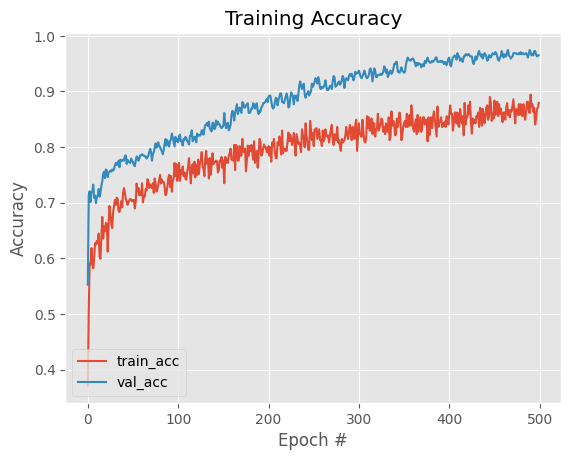

In [22]:
# plot training and val accuracy
plot_acc(H, 500)

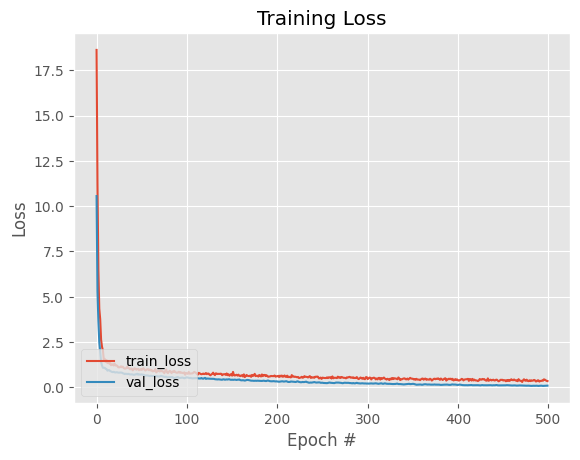

In [23]:
# plot training and val loss
plot_loss(H, 500)

In [ ]:
# serialize the# serialize the model to disk

#print("[INFO] serializing network...")
#vgg_model2.save("vgg_model_500epochs.model", save_format="h5")

# Inference in Unseen Data

In [24]:
import imutils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

In [26]:
!dir

acc_output.png	 loss_output.png  vgg16_model_500epochs.model
classify-images  README.md	  wbc


In [33]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model
print("[INFO] loading network and...")
model = load_model("vgg16_model_500epochs.model")

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('/content/drive/MyDrive/medprime/Medprime_task/classify-images')))   # data folder with 8 categorical folders

all_classes = ["bands", "basophils", "blasts", "eosinophils", "lymphocytes","metamyelocytes","monocytes","myelocytes","neutrophils"]


# progress bar
with tqdm(total=len(testImagePaths)) as pbar:

    for imagePath in testImagePaths:

        image = cv2.imread(imagePath)
        output = image.copy()
        output = imutils.resize(output, width=400)

        # our model was trained on RGB ordered images but OpenCV represents
        # images in BGR order, so swap the channels, and then resize to
        # 224x224 (the input dimensions for VGG16)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        # convert the image to a floating point data type and perform mean
        # subtraction
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean



        # model = model

        # pass the image through the network to obtain our predictions
        preds = model.predict(np.expand_dims(image, axis=0))[0]
        i = np.argmax(preds)
        label = CLASSES[i]

        # draw the prediction on the output image
        text = "{}: {:.2f}%".format(label, preds[i] * 100)
        cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
            (0, 255, 0), 2)

         # convert img to rgb format and display in notebook
        img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        display_img(img)

        pbar.update(1)


[INFO] loading network and...


0it [00:00, ?it/s]

In [ ]:
# build gradio app
!pip install gradio

In [35]:
import gradio as gr


def predict_image(image):


    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean

    # pass the image through the network to obtain our predictions
    preds = model.predict(np.expand_dims(image, axis=0))[0]

    result = dict()
    result["bands"] = round(float(list(preds)[0]), 3)
    result["basophils"] = round(float(list(preds)[1]), 3)
    result["blasts"] = round(float(list(preds)[2]), 3)
    result["eosinophils"] = round(float(list(preds)[3]), 3)
    result["lymphocytes"] = round(float(list(preds)[4]), 3)
    result["metamyelocytes"] = round(float(list(preds)[5]), 3)
    result["monocytes"] = round(float(list(preds)[6]), 3)
    result["myelocytes"] = round(float(list(preds)[7]), 3)
    result["neutrophils"] = round(float(list(preds)[8]), 3)

    print(result)

    return result




In [36]:
im = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=3)
gr.Interface(fn = predict_image, inputs=im, outputs=label, capture_session=True, title="VGG WBC DEMO").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://27fcb1f09cdded6895.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
